<a href="https://colab.research.google.com/github/q759729997/qyt_python_collections/blob/master/ucas/%E8%AE%A1%E7%AE%97%E6%9C%BA%E8%A7%86%E8%A7%89/MidProject/mid_project_Unet_efficientnetb3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
!pip install -U albumentations
!pip install -U --pre segmentation-models

     |████████████████████████████████| 122kB 7.0MB/s 
     |████████████████████████████████| 952kB 12.8MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65164 sha256=ac6b98b84f14a4baf13be2af6ee8d4c69170c8e8532f97cd429ad1139567c89a
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


# Loading dataset

For this example we will use **煤矸石** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 480 pixels height and 852 pixels width.

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
DATA_DIR = '/content/drive/My Drive/data/cv/MidProject'

if not os.path.exists(DATA_DIR):
    print('Loading data...')
    print('Done!')

In [ ]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

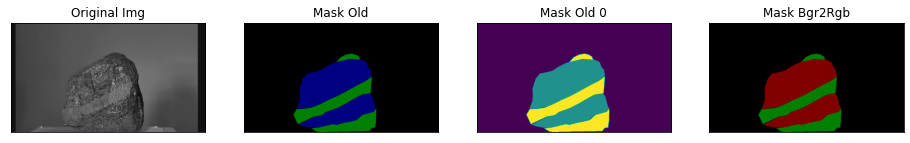

In [ ]:
# 图片查看
original_img = cv2.imread('/content/drive/My Drive/data/cv/MidProject/val/197.jpg')
mask_old = cv2.imread('/content/drive/My Drive/data/cv/MidProject/valannot/197.png')
mask_old_0 = cv2.imread('/content/drive/My Drive/data/cv/MidProject/valannot/197.png', 0)
mask_BGR2RGB = cv2.cvtColor(mask_old, cv2.COLOR_BGR2RGB)
visualize(
    original_img=original_img,
    mask_old=mask_old,
    mask_old_0=mask_old_0,
    mask_BGR2RGB=mask_BGR2RGB,
)

In [ ]:
# 图片查看
# original_img = cv2.imread('/content/drive/My Drive/data/cv/MidProject/train/157.jpg')
# mask_old = cv2.imread('/content/drive/My Drive/data/cv/MidProject/trainannot/157.png')
# mask_old_0 = cv2.imread('/content/drive/My Drive/data/cv/MidProject/trainannot/157.png', 0)
# mask_BGR2RGB = cv2.cvtColor(mask_old, cv2.COLOR_BGR2RGB)
# visualize(
#     original_img=original_img,
#     mask_old=mask_old,
#     mask_old_0=mask_old_0,
#     mask_BGR2RGB=mask_BGR2RGB,
# )

In [ ]:
from tqdm import tqdm

In [ ]:
# 查看mask的序号
# mask_nums = set()
# image_files = os.listdir(y_train_dir)
# for image_file in tqdm(image_files):
#   mask_image = cv2.imread(os.path.join(y_train_dir, image_file), 0)
#   for row_nums in list(mask_image):
#     for cell_num in row_nums:
#       mask_nums.add(cell_num)
# mask_nums = list(mask_nums)
# mask_nums.sort()
# print(mask_nums)
# 100%|██████████| 180/180 [01:19<00:00,  2.27it/s][0, 38, 75]

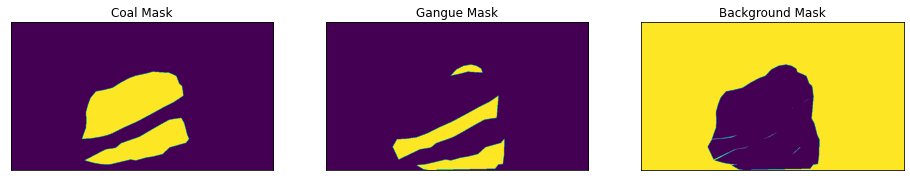

In [ ]:
masks = [(mask_old_0 == v) for v in [38, 75]]
# print(masks)
mask = np.stack(masks, axis=-1).astype('float')
# print(mask)
if mask.shape[-1] != 1:
  background = 1 - mask.sum(axis=-1, keepdims=True)
  mask = np.concatenate((mask, background), axis=-1)
# print(len(image), len(image[0]))
# print(len(mask), len(mask[0]))
visualize(
    coal_mask=mask[..., 0].squeeze(),
    gangue_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
)

# Dataloader and utility functions 

In [ ]:
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['coal', 'gangue']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id).replace('.jpg', '.png') for image_id in self.ids]
        print('ids len:{}, example:{}'.format(len(self.ids), self.ids[:3]))
        print('images_fps len:{}, example:{}'.format(len(self.images_fps), self.images_fps[:3]))
        print('masks_fps len:{}, example:{}'.format(len(self.masks_fps), self.masks_fps[:3]))
        
        # convert str names to class values on masks
        self.class_values = [38, 75]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        # mask = cv2.imread(self.masks_fps[i])
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

ids len:20, example:['197.jpg', '193.jpg', '191.jpg']
images_fps len:20, example:['/content/drive/My Drive/data/cv/MidProject/val/197.jpg', '/content/drive/My Drive/data/cv/MidProject/val/193.jpg', '/content/drive/My Drive/data/cv/MidProject/val/191.jpg']
masks_fps len:20, example:['/content/drive/My Drive/data/cv/MidProject/valannot/197.png', '/content/drive/My Drive/data/cv/MidProject/valannot/193.png', '/content/drive/My Drive/data/cv/MidProject/valannot/191.png']
480 852
480 852


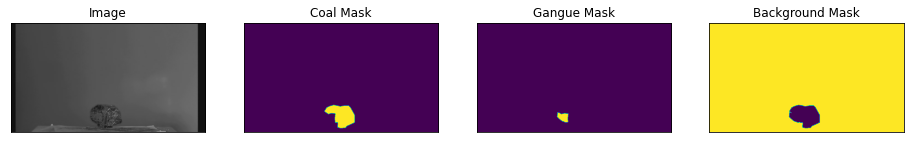

In [ ]:
# Lets look at data we have
dataset = Dataset(x_valid_dir, y_valid_dir, classes=['coal', 'gangue'])

image, mask = dataset[1] # get some sample
print(len(image), len(image[0]))
print(len(mask), len(mask[0]))
visualize(
    image=image, 
    coal_mask=mask[..., 0].squeeze(),
    gangue_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops


In [ ]:
import albumentations as A

In [ ]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        # A.HorizontalFlip(p=0.5),

        # A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        # A.IAAAdditiveGaussianNoise(p=0.2),
        # A.IAAPerspective(p=0.5),

        # A.OneOf(
        #     [
        #         A.CLAHE(p=1),
        #         A.RandomBrightness(p=1),
        #         A.RandomGamma(p=1),
        #     ],
        #     p=0.9,
        # ),

        # A.OneOf(
        #     [
        #         A.IAASharpen(p=1),
        #         A.Blur(blur_limit=3, p=1),
        #         A.MotionBlur(blur_limit=3, p=1),
        #     ],
        #     p=0.9,
        # ),

        # A.OneOf(
        #     [
        #         A.RandomContrast(p=1),
        #         A.HueSaturationValue(p=1),
        #     ],
        #     p=0.9,
        # ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(480, 864),  # Height and width of input image should be divisible by 32. You can pad it or resize.
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

ids len:180, example:['179.jpg', '175.jpg', '173.jpg']
images_fps len:180, example:['/content/drive/My Drive/data/cv/MidProject/train/179.jpg', '/content/drive/My Drive/data/cv/MidProject/train/175.jpg', '/content/drive/My Drive/data/cv/MidProject/train/173.jpg']
masks_fps len:180, example:['/content/drive/My Drive/data/cv/MidProject/trainannot/179.png', '/content/drive/My Drive/data/cv/MidProject/trainannot/175.png', '/content/drive/My Drive/data/cv/MidProject/trainannot/173.png']


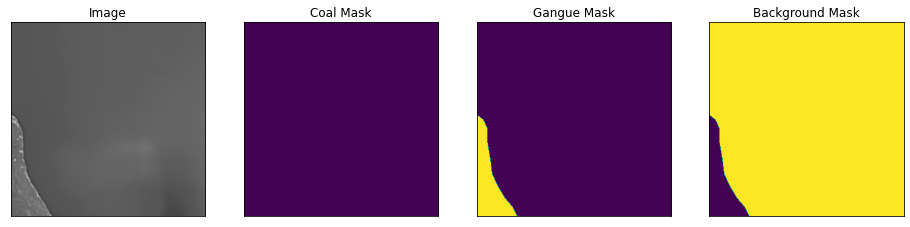

In [ ]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['coal', 'gangue'], augmentation=get_training_augmentation())

image, mask = dataset[12] # get some sample
visualize(
    image=image, 
    coal_mask=mask[..., 0].squeeze(),
    gangue_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
)

# Segmentation model training

In [ ]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `keras` framework.


In [ ]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
CLASSES = ['coal', 'gangue']
LR = 0.0001
EPOCHS = 100

preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

44113920/44107200 [==============================] - 2s 0us/step


In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 4 1080        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 4 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 4 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [ ]:
# # 数据集查看
# train_dataset = Dataset(
#     x_train_dir, 
#     y_train_dir, 
#     classes=CLASSES, 
#     # augmentation=get_training_augmentation(),
#     # preprocessing=get_preprocessing(preprocess_input),
# )
# image, mask = train_dataset[1] # get some sample
# print(len(image), len(image[0]))
# print(len(mask), len(mask[0]))

In [ ]:
# 排查错误图片
# for i in range(len(train_dataset)):
#   try:
#     image, mask = train_dataset[i] # get some sample
#     if (len(image), len(image[0])) != (480, 852):
#       print('image i:{}'.format(i))
#       print(len(image), len(image[0]))
#     if (len(mask), len(mask[0])) != (480, 852):
#       print('mask i:{}'.format(i))
#       print(len(mask), len(mask[0]))
#   except Exception:
#     print('Exception i:{}, id:{}'.format(i, train_dataset.ids[i]))
#     print(image)
#     print(mask)

In [ ]:
model_file_name = '/content/drive/My Drive/model_save/cv/mid_project/Unet_efficientnetb3_best_model.h5'

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint(model_file_name, save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.EarlyStopping(monitor='loss', patience=5)
]

ids len:180, example:['179.jpg', '175.jpg', '173.jpg']
images_fps len:180, example:['/content/drive/My Drive/data/cv/MidProject/train/179.jpg', '/content/drive/My Drive/data/cv/MidProject/train/175.jpg', '/content/drive/My Drive/data/cv/MidProject/train/173.jpg']
masks_fps len:180, example:['/content/drive/My Drive/data/cv/MidProject/trainannot/179.png', '/content/drive/My Drive/data/cv/MidProject/trainannot/175.png', '/content/drive/My Drive/data/cv/MidProject/trainannot/173.png']
ids len:20, example:['197.jpg', '193.jpg', '191.jpg']
images_fps len:20, example:['/content/drive/My Drive/data/cv/MidProject/val/197.jpg', '/content/drive/My Drive/data/cv/MidProject/val/193.jpg', '/content/drive/My Drive/data/cv/MidProject/val/191.jpg']
masks_fps len:20, example:['/content/drive/My Drive/data/cv/MidProject/valannot/197.png', '/content/drive/My Drive/data/cv/MidProject/valannot/193.png', '/content/drive/My Drive/data/cv/MidProject/valannot/191.png']


In [ ]:
print('train')
print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)
print('valid')
print(valid_dataloader[0][0].shape)
print(valid_dataloader[0][1].shape)

train
(8, 320, 320, 3)
(8, 320, 320, 3)
valid
(1, 320, 320, 3)
(1, 320, 320, 3)


In [ ]:
# 排查错误：ValueError: Requested crop size (320, 320) is larger than the image size (3, 1)
# for i in range(len(train_dataloader)):
#   for j in range(len(train_dataloader[i])):
#     if train_dataloader[i][j].shape == (BATCH_SIZE, 320, 320, 3):
#       continue
#     else:
#       print('i:{},j:{},data:{},shape:{}'.format(i, j, train_dataloader[i][j], train_dataloader[i][j].shape))

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/100
22/22 [==============================] - 212s 10s/step - loss: 0.7717 - iou_score: 0.2012 - f1-score: 0.3067 - val_loss: 0.7374 - val_iou_score: 0.1074 - val_f1-score: 0.1678
Epoch 2/100
22/22 [==============================] - 32s 1s/step - loss: 0.6874 - iou_score: 0.3915 - f1-score: 0.5119 - val_loss: 0.7551 - val_iou_score: 0.1735 - val_f1-score: 0.2472
Epoch 3/100
22/22 [==============================] - 32s 1s/step - loss: 0.5990 - iou_score: 0.5185 - f1-score: 0.6472 - val_loss: 0.8333 - val_iou_score: 0.0947 - val_f1-score: 0.1443
Epoch 4/100
22/22 [==============================] - 32s 1s/step - loss: 0.5335 - iou_score: 0.5850 - f1-score: 0.7062 - val_loss: 1.0155 - val_iou_score: 0.2172 - val_f1-score: 0.3176
Epoch 5/100
22/22 [==============================] - 32s 1s/step - loss: 0.4504 - iou_score: 0.6371 - f1-score: 0.7487 - val_loss: 0.6725 - val_iou_score: 0.5492 - val_f1-score: 0.6409
Epoch 6/100
22/22 [==============================] - 32s 1s/step - loss: 

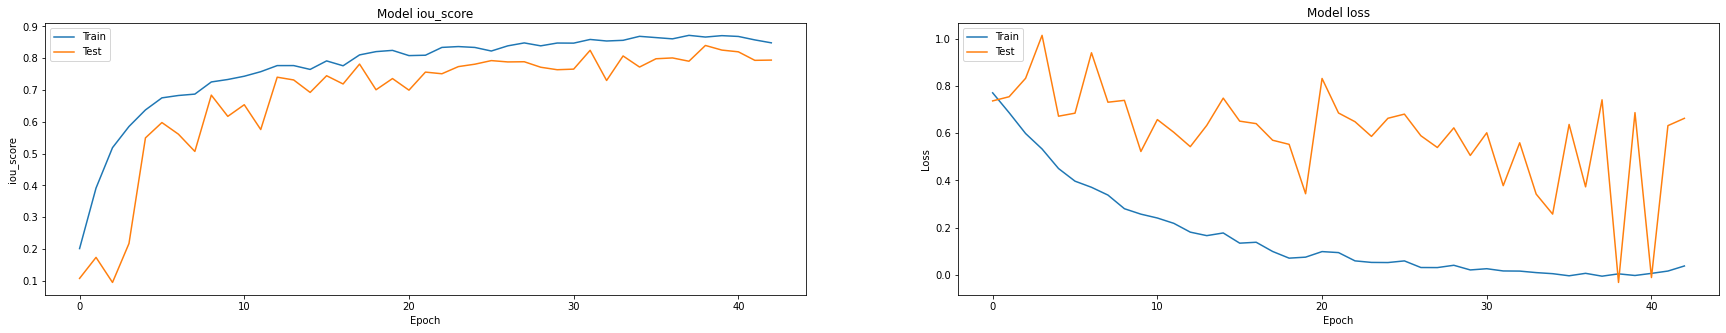

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model Evaluation

In [ ]:
# load best weights
model.load_weights(model_file_name) 

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

ids len:36, example:['209.jpg', '208.jpg', '212.jpg']
images_fps len:36, example:['/content/drive/My Drive/data/cv/MidProject/test/209.jpg', '/content/drive/My Drive/data/cv/MidProject/test/208.jpg', '/content/drive/My Drive/data/cv/MidProject/test/212.jpg']
masks_fps len:36, example:['/content/drive/My Drive/data/cv/MidProject/testannot/209.png', '/content/drive/My Drive/data/cv/MidProject/testannot/208.png', '/content/drive/My Drive/data/cv/MidProject/testannot/212.png']


In [ ]:
print('test')
print(test_dataloader[0][0].shape)
print(test_dataloader[0][1].shape)

test
(1, 480, 864, 3)
(1, 480, 864, 3)


In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.086914
mean iou_score: 0.81491
mean f1-score: 0.88489


# Visualization of results on test dataset

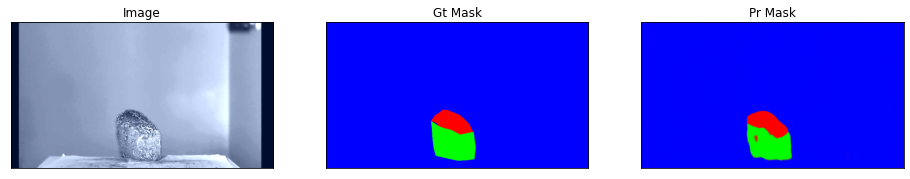

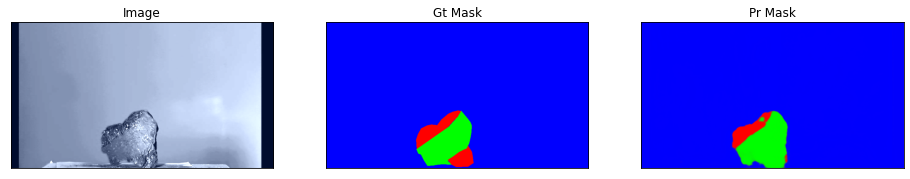

In [ ]:
n = 2
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    )
# InvalidArgumentError:  ConcatOp : Dimensions of inputs should match: shape[0] = [1,256,60,108] vs. shape[1] = [1,288,60,107]

实验结果展示

In [ ]:
from time import clock

序号：0
time:  0.169171 s
煤占比：0.4466


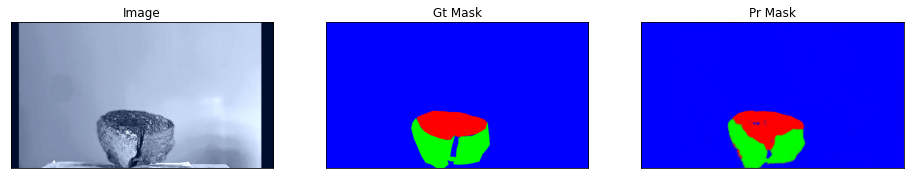

序号：1
time:   0.16825 s
煤占比：0.426


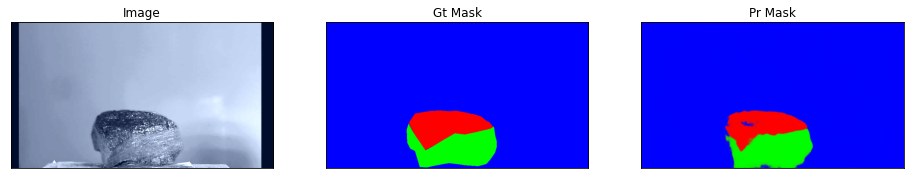

序号：2
time:  0.162639 s
煤占比：0.5754


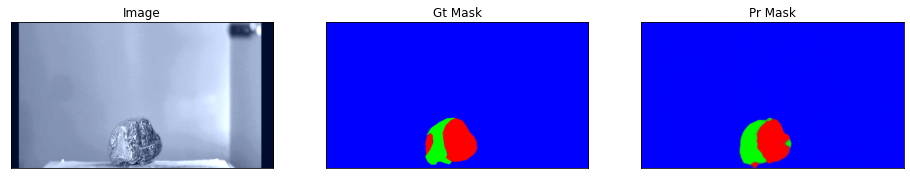

序号：3
time:  0.171311 s
煤占比：0.3381


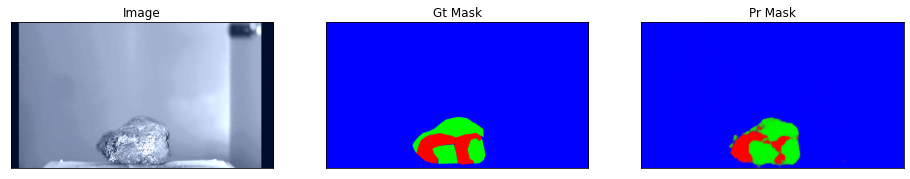

序号：4
time:  0.170588 s
煤占比：0.1444


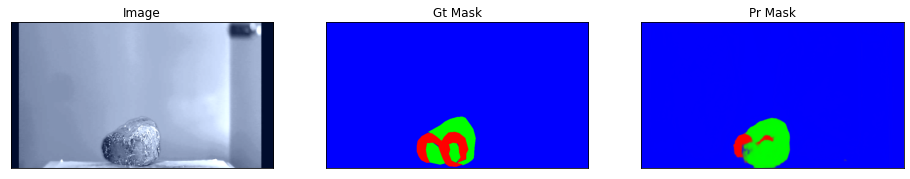

序号：5
time:  0.162922 s
煤占比：0.2864


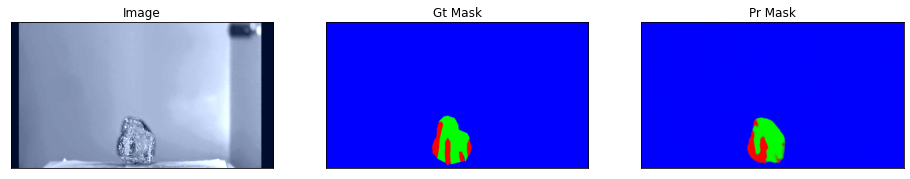

序号：6
time:  0.168029 s
煤占比：0.4764


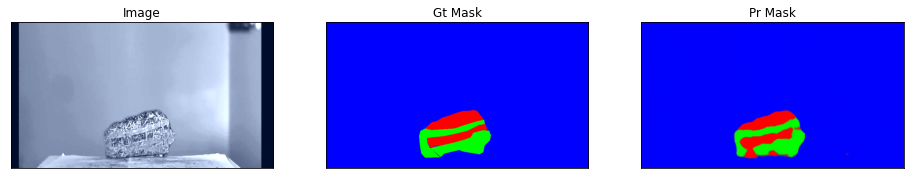

序号：7
time:   0.16962 s
煤占比：0.1756


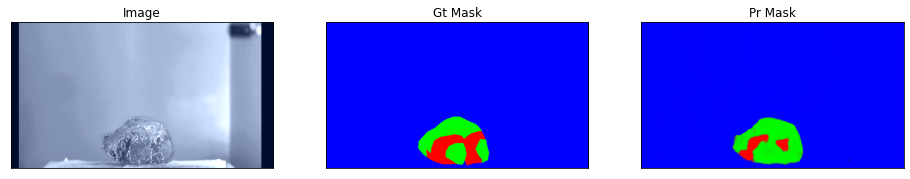

序号：8
time:  0.169384 s
煤占比：0.3242


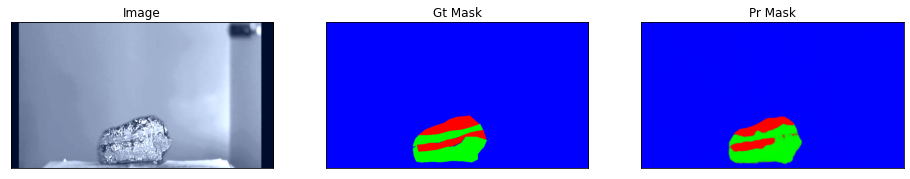

序号：9
time:  0.168799 s
煤占比：0.6588


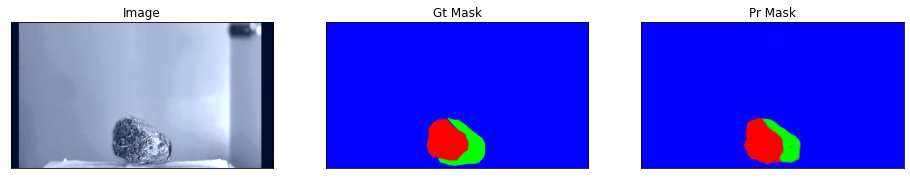

序号：10
time:  0.163375 s
煤占比：0.3633


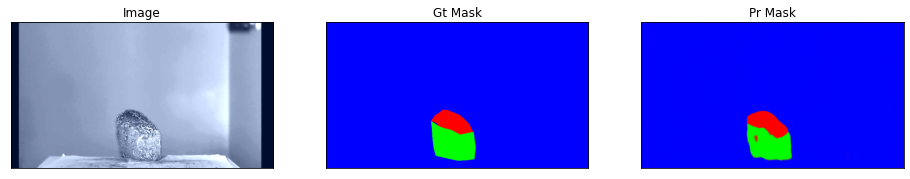

序号：11
time:   0.16692 s
煤占比：0.2169


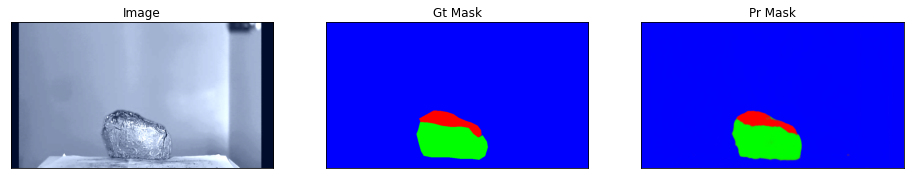

序号：12
time:  0.164581 s
煤占比：0.5221


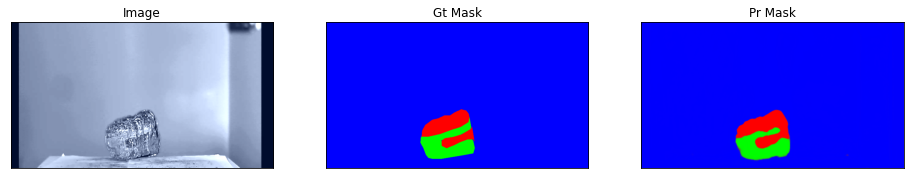

序号：13
time:  0.171101 s
煤占比：0.2707


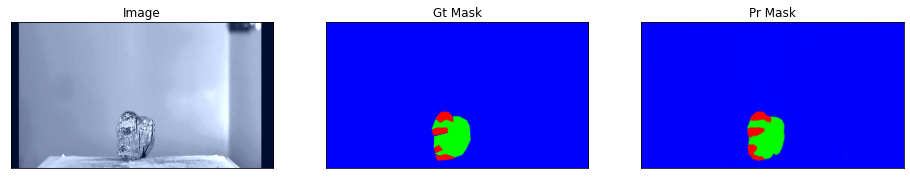

序号：14
time:   0.16988 s
煤占比：0.1609


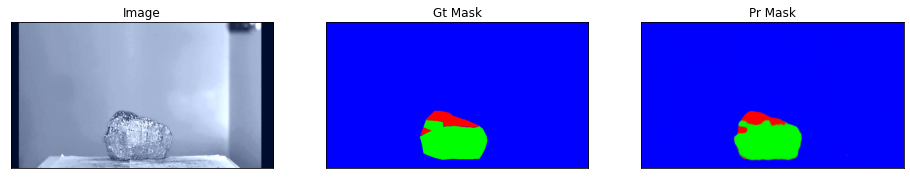

序号：15
time:  0.171116 s
煤占比：0.4059


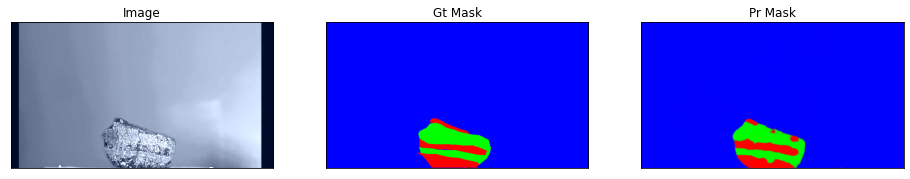

序号：16
time:  0.160799 s
煤占比：0.1321


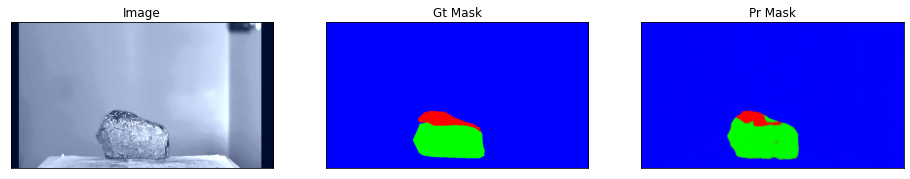

序号：17
time:  0.164132 s
煤占比：0.4991


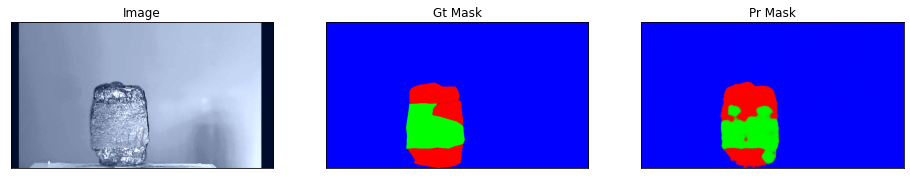

序号：18
time:  0.169675 s
煤占比：0.5835


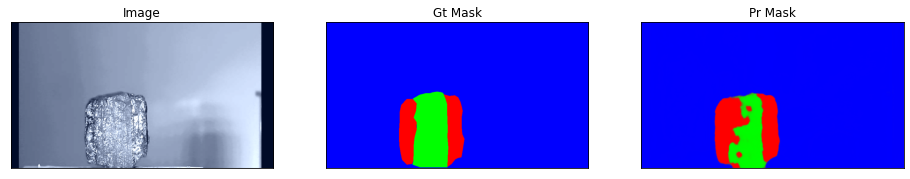

序号：19
time:  0.169602 s
煤占比：0.5611


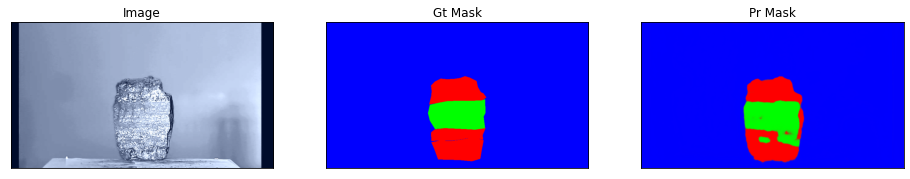

序号：20
time:   0.16288 s
煤占比：0.3873


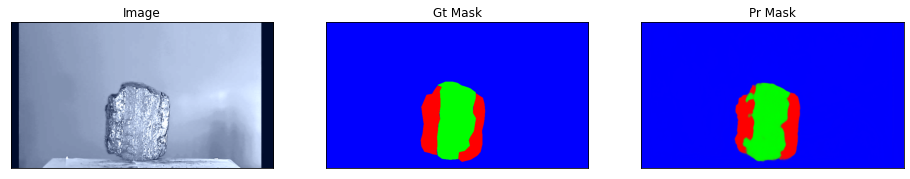

序号：21
time:  0.168933 s
煤占比：0.3473


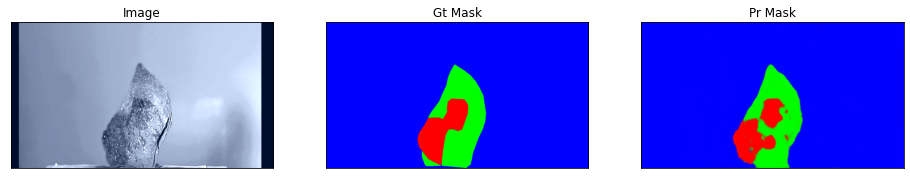

序号：22
time:  0.171201 s
煤占比：0.0452


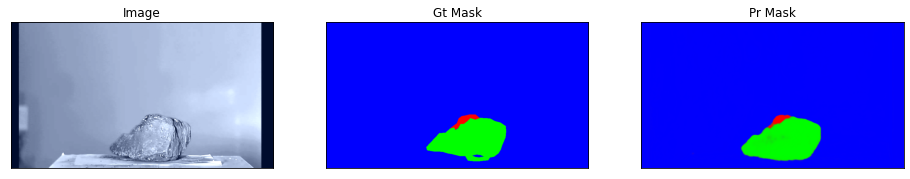

序号：23
time:  0.167284 s
煤占比：0.0277


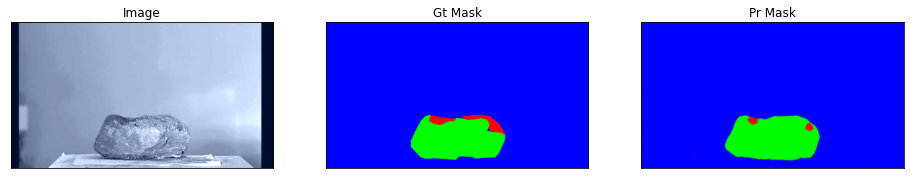

序号：24
time:  0.169846 s
煤占比：0.0794


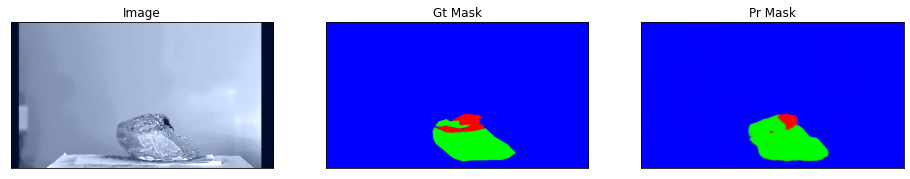

序号：25
time:  0.169729 s
煤占比：0.0391


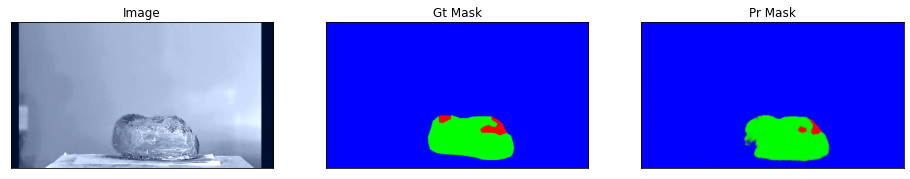

序号：26
time:  0.168881 s
煤占比：0.2659


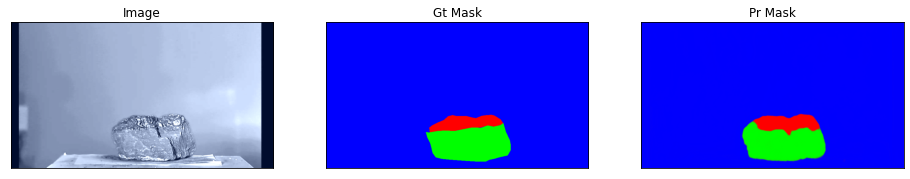

序号：27
time:   0.17265 s
煤占比：0.1501


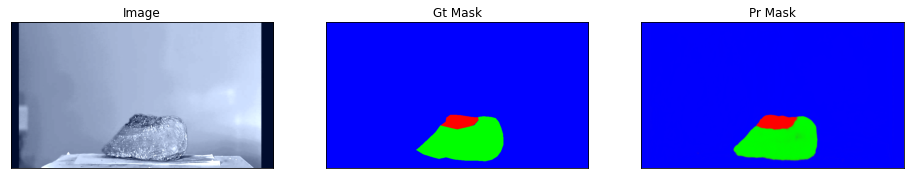

序号：28
time:  0.166504 s
煤占比：0.0381


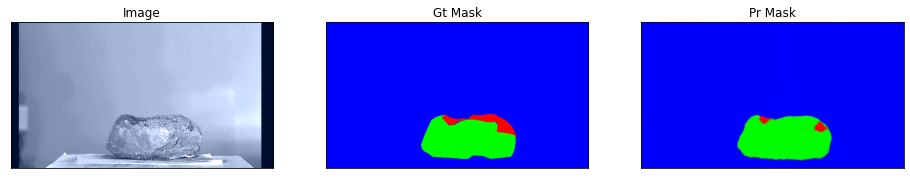

序号：29
time:  0.167658 s
煤占比：0.7324


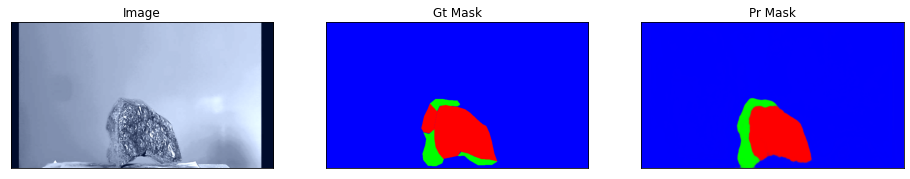

序号：30
time:  0.160839 s
煤占比：0.0525


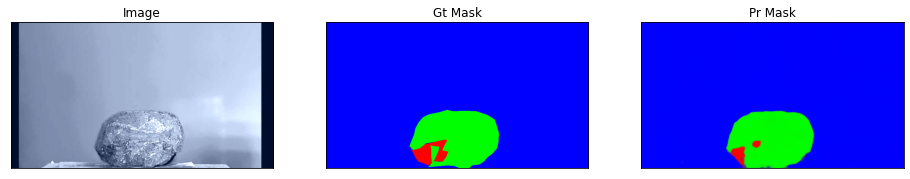

序号：31
time:  0.160715 s
煤占比：0.1603


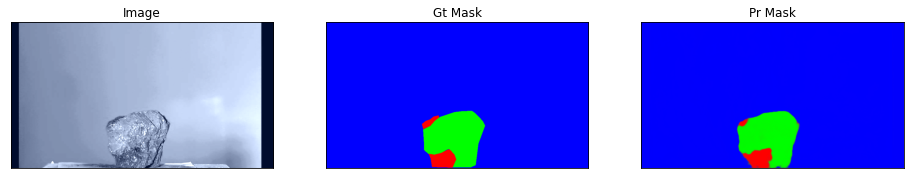

序号：32
time:  0.163444 s
煤占比：0.1298


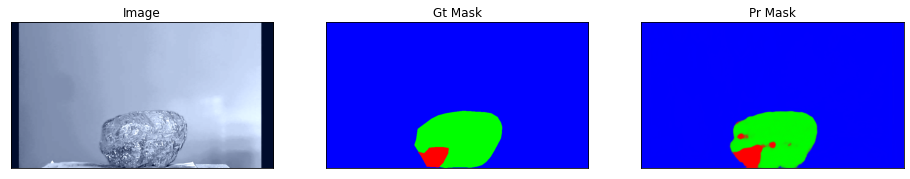

序号：33
time:  0.169134 s
煤占比：0.7255


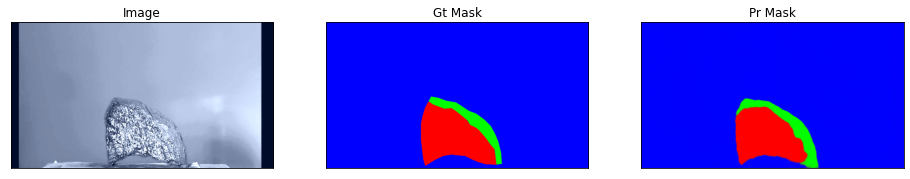

序号：34
time:  0.162603 s
煤占比：0.3743


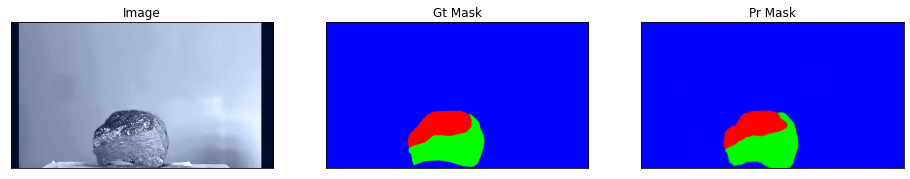

序号：35
time:  0.163546 s
煤占比：0.2148


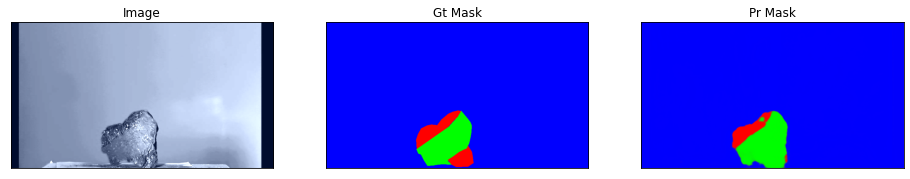

In [ ]:
for i in range(len(test_dataset)):
  print('序号：{}'.format(i))
  image, gt_mask = test_dataset[i]
  image = np.expand_dims(image, axis=0)
  # 预测与计算耗时
  start = clock()
  pr_mask = model.predict(image)
  finish = clock()
  print("time:{:10.6} s".format(finish - start))
  # 计算煤占比
  pr_mask_index = np.argmax(pr_mask, axis=3)
  num_coal = (pr_mask_index == 0).sum()
  num_gangue = (pr_mask_index == 1).sum()
  # print(num_coal)
  # print(num_gangue)
  print('煤占比：{}'.format(round(num_coal/(num_coal+num_gangue), 4)))
  visualize(
      image=denormalize(image.squeeze()),
      gt_mask=gt_mask.squeeze(),
      pr_mask=pr_mask.squeeze(),
  )
  

In [ ]:
# gt_mask = test_dataset[0][1]
# print(type(gt_mask))

In [ ]:
# print(pr_mask.shape) (1, 480, 864, 3)
# pr_mask_index = np.argmax(pr_mask, axis=3)
# num_coal = (pr_mask_index == 0).sum()
# num_gangue = (pr_mask_index == 1).sum()
# print(num_coal)
# print(num_gangue)
# print(round(num_coal/(num_coal+num_gangue), 4))